In [1]:
import os
import datetime
import cv2
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from imageai.Detection import ObjectDetection
from skimage import transform
from skimage.feature import hog
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

#------------------------------------- Extract Features ------------------------------------
    
def norm_image(img):
    return img/np.amax(img)

def get_hog_features(img):
    img = norm_image(transform.resize(img, (224, 224)))
#     img = normImage(transform.resize(img, (350, 350)))
    fd = hog(img, orientations=8,
             pixels_per_cell=(16, 16),
             cells_per_block=(1, 1))
    return fd

def get_features(img):
    return get_hog_features(img)
    
#------------------------------------- Train Model ------------------------------------
        
def load_dataset_to_features(dataset_path):
    img_list = []
    label_list = []
    for i, person_path in enumerate(os.listdir(dataset_path)):
        img_path = dataset_path+person_path+'/'
        for img_name in os.listdir(img_path):
            img = get_features(cv2.imread(img_path+img_name))
            img_list.append(img)
            label_list.append(i)
    return np.array(img_list), np.array(label_list)

def map_cluster_label(dataset_path, model):
    label_dict = {}
    for person_path in os.listdir(dataset_path):
        img_path = dataset_path+person_path+'/'        
        for img_name in os.listdir(img_path):
            img = get_features(cv2.imread(img_path+img_name))
            label_dict[person_path] = model.predict([img])[0]
            break
    return label_dict

#------------------------------------- Visualize ------------------------------------

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False,
                          title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Using TensorFlow backend.


C:\Users\dolla\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\dolla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dolla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dolla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dolla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning

C:\Users\dolla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dolla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dolla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dolla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dolla\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

Confusion matrix, without normalization
[[10  0  0  0  0  0]
 [ 0 10  1  0  0  2]
 [ 0  0  4  0  1  4]
 [ 0  1  0  4  0  2]
 [ 1  1  0  0 11  1]
 [ 0  0  1  0  1  9]]


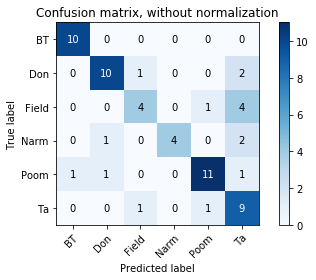

In [5]:
#------------------------------------- Main ------------------------------------
dataset_path = 'dataset/'
person_dict = dict(zip(range(len(os.listdir(dataset_path))), os.listdir(dataset_path)))

# load data -> get features
fd_list, lb_list = load_dataset_to_features(dataset_path)
fd_train, fd_test, lb_train, lb_test = train_test_split(fd_list, lb_list, test_size=0.33, random_state=0)

# train model
# k = np.max(lb_list)+2
# model = MiniBatchKMeans(n_clusters=k).fit(fd_list)
# label_dict = map_cluster_label(dataset_folder, model)
params = {'C':[10**n for n in range(-5, 6)]}
model = GridSearchCV(LogisticRegression(), params).fit(fd_train, lb_train).best_estimator_
# save model
dt = str(datetime.datetime.now()).replace(' ', '').replace('-', '').replace(':', '').replace('.', '')
pickle.dump(model, open('face_id.h5', 'wb'))

# test model
lb_res = model.predict(fd_test)
plot_confusion_matrix(lb_test, lb_res, classes=np.array(list(person_dict.values())),
                      normalize=False, title=None, cmap=plt.cm.Blues)

In [7]:
#------------------------------------- Line ------------------------------------
def notify_message(message):
    payload = {'message':message}
    return _line_notify(payload)

def notify_file(filepath, description='Recieve file'):
    file = {'imageFile':open(filepath, 'rb')}
    payload = {'message':description}
    return _line_notify(payload, file)

def _line_notify(payload, file=None):
    url = 'https://notify-api.line.me/api/notify'
    token = 'TUVIfnWavJSlEwFcsU9b7I2mfg4RHjc9422PYuZp9hC'
    headers = {'Authorization':'Bearer '+token}
    r = requests.post(url, headers=headers , data=payload, files=file)
    print('<status {}> : {}'.format(r.json()['status'], payload))

#------------------------------------- Detection ------------------------------------

# return (face detection image, identified face)
def detect_face(img, face_cascade, model, person_dict):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)
#     iden_faces = ['\nUnknown']*len(faces)
    if len(faces) == 0:
        return img, ['\nUnknown']
    iden_faces = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face_img = get_features(img[y:y+h, x:x+w, :])
        label = model.predict([face_img])[0]
        iden_faces.append('\n'+person_dict[label])
    return img, iden_faces

# return (obj detection image path, identified person list)
def detect_object(img, detector, face_cascade, model, person_dict):
    image_folder = 'detected/'
    detection_img, detection_obj, detection_obj_img = detector.detectObjectsFromImage(input_image=img, 
                                                                                      input_type='array',
                                                                                      output_type='array',
                                                                                      extract_detected_objects=True)
    iden_person_list = []
    found_person = 0
    for obj, obj_img in zip(detection_obj, detection_obj_img):
        if obj['name'] == 'person':
            face_img, iden_person = detect_face(obj_img, face_cascade, model, person_dict)
            iden_person_list.extend(iden_person)
            dt = str(datetime.datetime.now()).replace(' ', '_').replace(':', '-').replace('.', '_')
            image_path = image_folder+dt+'_'+str(found_person)+'.jpg'
            cv2.imwrite(image_path, face_img)
            found_person += 1
    if found_person > 0:
        dt = str(datetime.datetime.now()).replace(' ', '_').replace(':', '-').replace('.', '_')
        image_path = image_folder+dt+'.jpg'
        cv2.imwrite(image_path, detection_img)
        return image_path, iden_person_list
    return None, None

#------------------------------------- Video ------------------------------------

def capture_video(model, person_dict):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    detector = ObjectDetection()
    detector.setModelTypeAsRetinaNet()
    detector.setModelPath(os.path.join(os.getcwd() , "resnet50_coco_best_v2.0.1.h5"))
    detector.loadModel()
    cap = cv2.VideoCapture(0)
    while(cv2.waitKey(1) & 0xFF != ord('q')):
        ret, frame = cap.read()
        img_path, iden_person_list = detect_object(frame, detector, face_cascade,
                                                   model, person_dict)
        if img_path:
            notify_file(img_path, ''.join(iden_person_list))
            break
    cap.release()
    cv2.destroyAllWindows()
    
#------------------------------------- Main ------------------------------------
dataset_path = 'dataset/'
person_dict = dict(zip(range(len(os.listdir(dataset_path))), os.listdir(dataset_path)))

# load model -> test real time
model = pickle.load(open('face_id.h5', 'rb'))
capture_video(model, person_dict)

<status 200> : {'message': '\nField'}


In [8]:
import os
import cv2
import numpy as np

#------------------------------------- Data ------------------------------------

def rename_image(dataset_path, person_path):
    img_path = dataset_path+person_path+'/'
    for i, img_name in enumerate(os.listdir(img_path)):
        os.rename(img_path+img_name, '{}{}{}.jpg'.format(img_path, person_path, i))

def crop_face(dataset_path, person_path):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    img_path = dataset_path+person_path+'/'
    for img_name in os.listdir(img_path):
        img = cv2.imread(img_path+img_name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.2, 5)
        for i, (x,y,w,h) in enumerate(faces):
            tmp_img = img[y:y+h, x:x+w, :]
            cv2.imwrite(img_path+img_name.replace('.', '_{}.'.format(i)), tmp_img)

dataset_path = 'dataset/'

# rename_image(dataset_path, 'BT')
# crop_face(dataset_path, 'BT')

# rename_image(dataset_path, 'Don')
# crop_face(dataset_path, 'Don')

# rename_image(dataset_path, 'Field')
# crop_face(dataset_path, 'Field')

# rename_image(dataset_path, 'Narm')
# crop_face(dataset_path, 'Narm')

# rename_image(dataset_path, 'Poom')
# crop_face(dataset_path, 'Poom')

# rename_image(dataset_path, 'Ta')
# crop_face(dataset_path, 'Ta')

# Other version function

In [ ]:
#------------------------------------- Face Detection ------------------------------------
    
# return (face detection image, number of face)
def detect_face(img, face_cascade):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    return img, len(faces)

# return (face detection image, identified face)
def detect_face(img, face_cascade):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)
    iden_faces = ['\nUnknown']*len(faces)
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    return img, iden_faces

#------------------------------------- Obj Detection ------------------------------------

# return (obj detection image path, obj list)
def detect_object(img, detector):
    detection_img, detection_obj = detector.detectObjectsFromImage(input_image=img,
                                                                   input_type='array',
                                                                   output_type='array')
    image_path = None
    obj_list = ['\n> '+obj["name"] for obj in detection_obj]
    if '\n> person' in obj_list:
        dt = str(datetime.datetime.now()).replace(' ', '_').replace(':', '-').replace('.', '_')
        image_path = 'detected/'+dt+'.jpg'
        cv2.imwrite(image_path, detection_img)
    return image_path, obj_list

# return (obj detection image path), stop when found person
def detect_object(img, detector):
    detection_img, detection_obj = detector.detectObjectsFromImage(input_image=img,
                                                                   input_type='array',
                                                                   output_type='array')
    for obj in detection_obj:
        if obj["name"] == 'person':
            dt = str(datetime.datetime.now()).replace(' ', '_').replace(':', '-').replace('.', '_')
            image_path = 'detected/'+dt+'.jpg'
            cv2.imwrite(image_path, detection_img)
            return image_path
        
# return (obj detection image path, identified person list), stop when found person
def detect_object(img, detector, face_cascade):
    detection_img, detection_obj = detector.detectObjectsFromImage(input_image=img,
                                                                   input_type='array',
                                                                   output_type='array')
    for obj in detection_obj:
        if obj["name"] == 'person':
            detection_img, iden_person = detect_face(detection_img, face_cascade)
            dt = str(datetime.datetime.now()).replace(' ', '_').replace(':', '-').replace('.', '_')
            image_path = 'detected/'+dt+'.jpg'
            cv2.imwrite(image_path, detection_img)
            return image_path, iden_person
    return None, None


#--------------------------------------------------------------------                
        img_path = detect_object(frame, detector)
        if img_path:
            notify_file(img_path, 'Found person!')
            break
#--------------------------------------------------------------------        
        img_path, obj_list = detect_object(frame, detector)
        if img_path:
            notify_file(img_path, ''.join(obj_list))
            break
#--------------------------------------------------------------------
        frame, nface = detect_face(frame)
        if nface > 0:
            send_notify('\nFound {} face(s)'.format(nface))
        cv2.imshow('frame', frame)
#--------------------------------------------------------------------